# Machine Learning for Time Series Data in Python - Part 2

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_iris
from sklearn.datasets import load_boston

import librosa as lr
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow

from glob import glob

## Time Series as Inputs to a Model

### Many repetitions of sounds
In this exercise, you'll start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.

You'll use the heartbeat data described in the last chapter. Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if you can spot the difference.

Two DataFrames, normal and abnormal, each with the shape of (n_times_points, n_audio_files) containing the audio for several heartbeats are available in your workspace. Also, the sampling frequency is loaded into a variable called sfreq. A convenience plotting function show_plot_and_make_titles() is also available in your workspace.

In [122]:
data_dir = '../datasets/Heartbeat Sounds'
normal_audio_files = glob(data_dir + '/normal_*.wav')
abnormal_audio_files = glob(data_dir + '/murmur_*.wav')

In [123]:
normal = [lr.load(file) for file in normal_audio_files]

In [124]:
abnormal = [lr.load(file) for file in abnormal_audio_files]

In [125]:
min_length_normal = min([len(a[0]) for a in normal])
min_length_abnormal = min([len(a[0]) for a in abnormal])
min_length = min(min_length_normal, min_length_abnormal)

sfreq = normal[0][1]
sfreq, min_length_normal, min_length_abnormal, min_length

(22050, 76369, 20647, 20647)

In [126]:
normal = np.array([a[0][:min_length] for a in normal]).T
abnormal = np.array([a[0][:min_length] for a in abnormal]).T
normal.shape, abnormal.shape

((20647, 31), (20647, 34))

In [127]:
# Calculate the time array
time = np.arange(normal.shape[0]) / sfreq

In [128]:
normal = pd.DataFrame(normal, index=[time])
normal.index.name = 'time'
normal.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-0.001461,0.001008,-0.000554,-0.000287,0.000152,0.006436,-0.002944,0.000572,0.000372,0.000102,...,0.000525,0.002572,-0.513040,0.011383,-0.000002,0.012362,0.003393,-0.001485,0.000983,0.000222
0.000045,-0.006714,0.002232,-0.000925,-0.000333,0.000045,0.008510,-0.005259,0.000652,0.000374,0.000147,...,0.000365,0.004159,-0.745410,0.018172,0.000394,0.017533,0.004958,-0.001358,0.001266,0.000273
0.000091,-0.002860,0.004334,-0.000357,-0.001512,-0.000105,0.004068,-0.004813,0.001374,0.000043,0.000105,...,0.000415,0.004093,-0.647746,0.017089,0.000874,0.014936,0.004857,-0.000767,0.001284,-0.000385
0.000136,-0.000548,0.004405,0.000178,-0.004786,-0.000057,0.001876,-0.004460,0.001152,0.000183,0.000194,...,0.000907,0.004526,-0.696535,0.018172,0.000842,0.016414,0.005036,-0.000643,0.001741,-0.000176
0.000181,-0.003240,0.005345,0.000268,-0.005374,-0.000092,-0.001555,-0.003118,0.001169,0.000044,0.000113,...,0.000819,0.004389,-0.643701,0.016539,0.001297,0.015227,0.004060,-0.001457,0.001932,-0.000049


In [129]:
abnormal = pd.DataFrame(abnormal, index=[time])
abnormal.index.name = 'time'
abnormal.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-0.168317,-0.002035,0.113057,-0.031637,-0.185096,-0.013211,0.004103,-0.025717,-0.102160,-0.000616,...,0.102205,0.008200,-0.008956,-0.000289,0.002513,0.037916,0.010673,-0.000614,0.001141,-0.005342
0.000045,-0.270060,-0.003049,0.181618,-0.050700,-0.296707,-0.021293,0.006612,-0.041243,-0.164134,-0.001028,...,0.149692,0.011669,-0.014323,0.000101,0.002914,0.054274,0.017101,-0.000937,0.001944,-0.007489
0.000091,-0.255433,-0.002897,0.172172,-0.047796,-0.280282,-0.020425,0.006415,-0.038827,-0.155556,0.000346,...,0.132061,0.009677,-0.013486,0.000897,0.002347,0.045937,0.016136,-0.000852,-0.000047,-0.006119
0.000136,-0.272905,-0.003179,0.184313,-0.050911,-0.299051,-0.022089,0.006997,-0.041403,-0.166525,0.000138,...,0.143423,0.010820,-0.014321,0.002287,0.001097,0.048478,0.017117,-0.000864,-0.002236,-0.006209
0.000181,-0.249984,-0.002946,0.169395,-0.046451,-0.273499,-0.020629,0.006671,-0.037815,-0.153068,-0.000393,...,0.134756,0.010579,-0.012997,0.002742,-0.000427,0.044800,0.015494,-0.000738,-0.003321,-0.005353


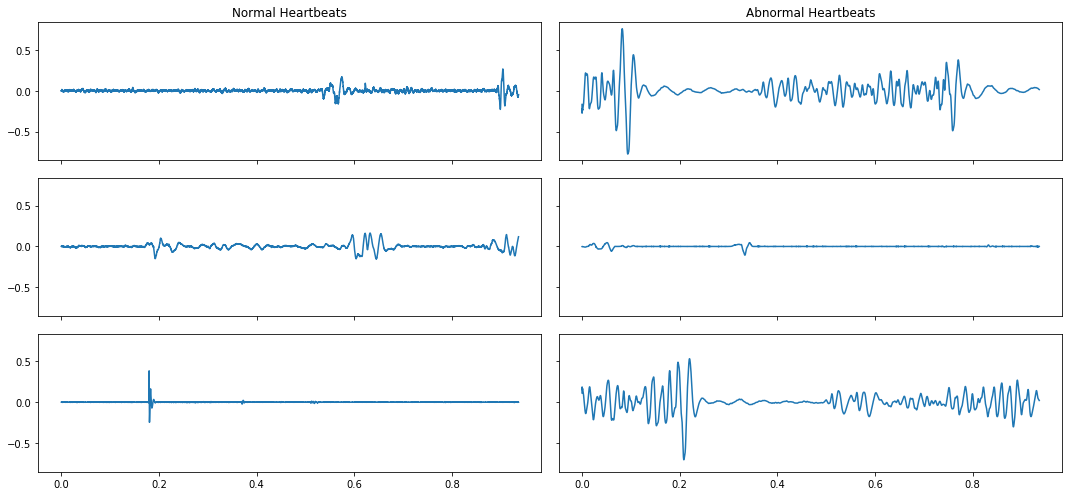

In [131]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal.iloc[:,:3], abnormal.iloc[:,:3]]).T

# Loop through each audio file / ax object and plot
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)

axs[0, 0].set(title="Normal Heartbeats")
axs[0, 1].set(title="Abnormal Heartbeats")
plt.tight_layout()
plt.show()

### Invariance in time
While you should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

In this exercise, you'll average across many instances of each class of heartbeat sound.

The two DataFrames (normal and abnormal) and the time array (time) from the previous exercise are available in your workspace.

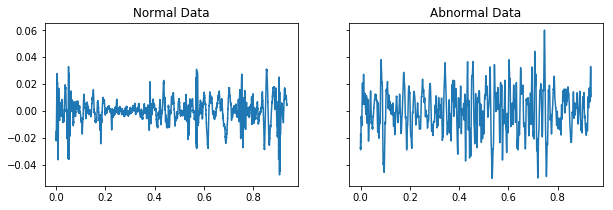

In [132]:
# Average across the time dimension of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

### Build a classification model
While eye-balling differences is a useful way to gain an intuition for the data, let's see if you can operationalize things with a model. In this exercise, you will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

We've split the two DataFrames (normal and abnormal) into X_train, X_test, y_train, and y_test.

In [161]:
X = np.hstack([normal, abnormal]).T

In [135]:
y_normal = np.full((normal.shape[1], 1), 'normal')
y_abnormal = np.full((abnormal.shape[1], 1), 'abnormal')
y = np.vstack([y_normal, y_abnormal])

In [164]:
X.shape, y.shape

((65, 20647), (65, 1))

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [137]:
# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [138]:
# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.470588235294


### Calculating the envelope of sound
One of the ways you can improve the features available to your model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then half-wave-rectify it so that the total amount of sound energy over time is more distinguishable. You'll do this in the current exercise.

A heartbeat file is available in the variable audio.

In [151]:
audio = normal.iloc[:,0]

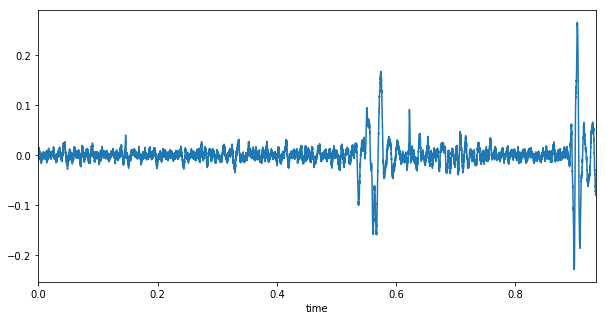

In [152]:
# Plot the raw data first
audio.plot(figsize=(10, 5))
plt.show()

In [153]:
# Rectify the audio signal
audio_half_wave = audio.apply(np.abs)

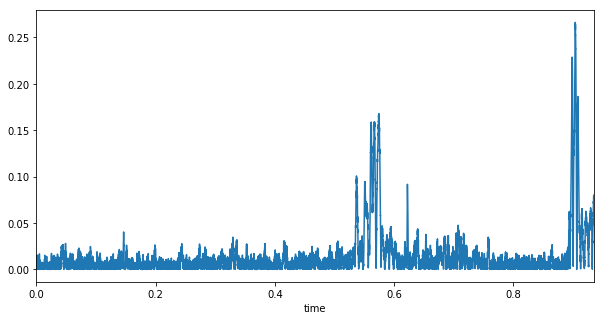

In [154]:
# Plot the result
audio_half_wave.plot(figsize=(10, 5))
plt.show()

In [155]:
# Smooth by applying a rolling mean
audio_half_wave_smooth = audio_half_wave.rolling(50).mean()

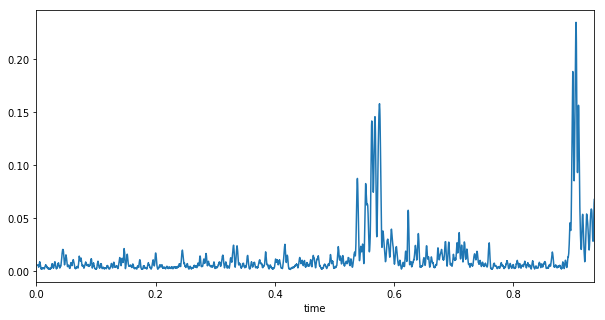

In [156]:
# Plot the result
audio_half_wave_smooth.plot(figsize=(10, 5))
plt.show()

### Calculating features from the envelope
Now that you've removed some of the noisier fluctuations in the audio, let's see if this improves your ability to classify.

audio_half_wave_smooth from the previous exercise is available in your workspace.

In [185]:
audio = pd.concat([normal, abnormal], axis=1)
audio_half_wave = audio.apply(np.abs)
audio_half_wave_smooth = audio_half_wave.rolling(50).mean()

In [186]:
# Calculate stats
means = np.mean(audio_half_wave_smooth, axis=0)
stds = np.std(audio_half_wave_smooth, axis=0)
maxs = np.max(audio_half_wave_smooth, axis=0)

In [187]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs])

In [188]:
X.shape, y.shape

((65, 3), (65, 1))

In [189]:
# Fit the model and score on testing data
model = LinearSVC()
percent_score = cross_val_score(model, X, y[:,0], cv=5)
print(np.mean(percent_score))

0.644322344322


### Derivative features: The tempogram
One benefit of cleaning up your data is that it lets you compute more sophisticated features. For example, the envelope calculation you performed is a common technique in computing tempo and rhythm features. In this exercise, you'll use librosa to compute some tempo and rhythm features for heartbeat data, and fit a model once more.

Note that librosa functions tend to only operate on numpy arrays instead of DataFrames, so we'll access our Pandas data as a Numpy array with the .values attribute.

In [192]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

In [193]:
# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

In [194]:
# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

In [195]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])

In [197]:
# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y[:,0], cv=5)
print(np.mean(percent_score))

0.521978021978


### Spectrograms of heartbeat audio
Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. In this exercise, you'll calculate a spectrogram of a heartbeat audio file.

We've loaded a single heartbeat sound in the variable audio.

In [232]:
audio = normal.iloc[:,0]

In [233]:
# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio.values, hop_length=HOP_LENGTH, n_fft=2**7)

In [220]:
# Convert into decibels
spec_db = amplitude_to_db(spec)

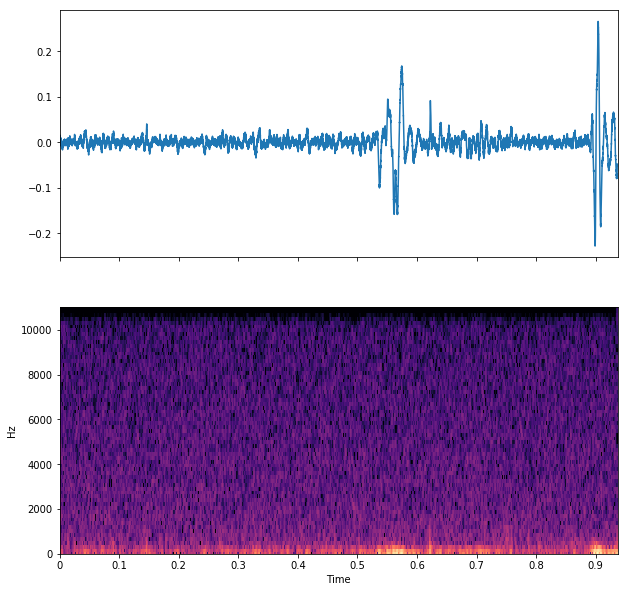

In [221]:
# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

### Engineering spectral features
As you can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, you have a much better idea of what's going on. As such, there are all kinds of spectral features that you can compute using the spectrogram as a base. In this exercise, you'll look at a few of these features.

The spectogram spec from the previous exercise is available in your workspace.

In [225]:
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

In [228]:
# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

In [ ]:
# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(time, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

### Combining many features in a classifier
You've spent this lesson engineering many features from the audio data - some contain information about how the audio changes in time, others contain information about the spectral content that is present.

The beauty of machine learning is that it can handle all of these features at the same time. If there is different information present in each feature, it should improve the classifier's ability to distinguish the types of audio. Note that this often requires more advanced techniques such as regularization, which we'll cover in the next chapter.

For the final exercise in the chapter, we've loaded many of the features that you calculated before. Combine all of them into an array that can be fed into the classifier, and see how it does.

In [ ]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)

In [ ]:
# Create X and y arrays
X = np.column_stack([means, stds, maxs, tempo_mean, tempo_max, tempo_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

In [ ]:
# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))